In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('liabilities.csv')
df2 = pd.read_csv('bonds.csv')

In [3]:
df2

,Bond,Price,Coupon,StartTime,Maturity
0,1,102,5.0,0,1
1,2,100,3.0,1,2
2,3,99,3.5,0,2
3,4,101,4.0,0,2
4,5,98,2.5,0,3
5,6,98,4.0,0,4
6,7,98,2.0,2,4
7,8,104,9.0,0,5
8,9,100,6.0,0,5
9,10,101,8.0,0,6


In [11]:
df2.loc[1,'Maturity']

2

In [17]:
def find_cf(df, df2, sensitivity = 0, plot = False):

    # The matrix A will convey the weights for our decision variables. 
    # For example, A[1,2] indicates the amount that one unit of bond2 
    # will bring at the end of the first year. 
    
    A = np.zeros((len(df),len(df2))) # A[year, bond]
    
    # We fill in the matrix A based on the information of each bond.
    for i in range(len(df2)):
        
        # If a bond starts at the first time frame, i.e. start time = 0
        # We take into account only the face value and coupon.
        
        # In other words, we do not consider the purchasing price of
        # a bond starting at the first year, as the cash flow 
        # should have been pondered earlier.
        
        if df2["StartTime"][i] == 0:
            
            # Before maturity, we get coupon only 
            A[:df2["Maturity"][i]-1,i] = df2["Coupon"][i]
            
            # At maturity, We get face + coupon
            A[df2["Maturity"][i]-1,i] = 100+df2["Coupon"][i]
        
        # In case of the bonds where (StartTime != 0)
        # We need to consider the expenditure taken to buy the bonds. 
        else:
            # When the bond starts, purchasing cost occurs
            A[df2["StartTime"][i]-1,i] = -df2["Price"][i]
            
            # Before maturity
            A[df2["StartTime"][i]:df2["Maturity"][i]-1,i] = df2["Coupon"][i]
            
            # At maturity
            A[df2["Maturity"][i]-1,i] = 100+df2["Coupon"][i]
    
    # Interested in the number of bond should be purchased for each type of bond.
    obj = np.array([0]*len(df2))
    
    # We have input the current price, only if it should be bought today
    # As the future cash outflow should be covered by the cash inflow from the bonds
    # We purchase today. 
    for p in range(len(df2)):
        if(df2['StartTime'][p]==0):
            obj[p] = df2['Price'][p]          
    
    #Set the RHS of our constraints as the value of the liabilities of each year. 
    B = np.array(df["Liability"])
    sense = np.array(['>']*len(df))
    
    bond_Model = gp.Model() # initialize model
    bond_ModX = bond_Model.addMVar(len(df2)) # tell gurobi how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    bond_ModCon = bond_Model.addMConstrs(A, bond_ModX, sense, B) # add the constraints to the model
    bond_Model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model
    
    #Keep the model quiet
    bond_Model.Params.OutputFlag = 0
    
    #Run the optimize
    bond_Model.optimize()
    print("Optimal Value:",bond_Model.objVal)
    
    # Most of parts have been done. 
    # Let's bring the shadow price, lower bound, upper bound, and liabilities 
    # and make them located in a new data frame. 
    sensitivity = pd.DataFrame()
    sensitivity['Shadow Price'] = [con.Pi for con in bond_ModCon]
    sensitivity['Lower Bound'] =  [con.SARHSLow for con in bond_ModCon]
    sensitivity['Upper Bound'] =  [con.SARHSUp for con in bond_ModCon]
    sensitivity['Liabities'] = df['Liability']
    
    #Create new data frame which will contain information on the number of bonds. 
    bonds = pd.DataFrame()
    
    #Copy the name of bonds from the original data set into the newly created data frame. . 
    bonds['Bond'] = df2['Bond']
    
    #Bring the number of each bond from our model. 
    bonds['Number of Bonds'] = bond_ModX.x
    
    
    if plot == True:
        # plot cash flows
        v = bond_ModX.x.tolist()
        lst = []
        for z in A:
            prod = [b * c for b,c in zip(z, v)]
            d = sum(prod)
            lst.append(d)
        
        #Set the figure size 
        plt.figure(figsize=(8,6))
        
        #Show how much money will be spent each year
        #If our optimization is correct, the two lines will be overlapped together. 
        plt.plot(list(df['Year']), list(df['Liability']), label = 'Liability')
        plt.plot(list(df['Year']), lst, label = "Dedicated Portfolio Cash Flow")
        plt.title('Cash Flows')
        plt.xlabel('Year')
        plt.ylabel('U.S. Dollars (Million of $)')
        plt.legend()
        plt.show()
        
        # plot pie chart
        prod = [b * c for b,c in zip(list(df2['Price']), v)]
        plt.figure(figsize=(8,6))
        bond = ['Bond ' + str(x) for x in list(df2['Bond'])]
        plt.pie(prod, labels = bond, autopct='%1.1f%%')
        plt.title('Percentage of Total Expenditure for each Bond')
        plt.show()
        

    
    print(bonds)
    print()
    print(sensitivity)


Optimal Value: 9447500.757413374


/var/folders/gp/5lrc5h3s21d02v2rsj713dxw0000gn/T/ipykernel_22784/2301193631.py:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  find_cf(df,df2,1, plot=True)


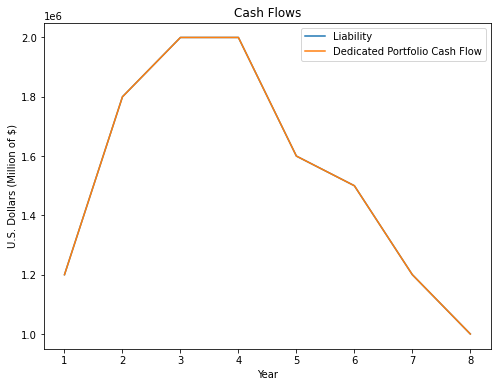

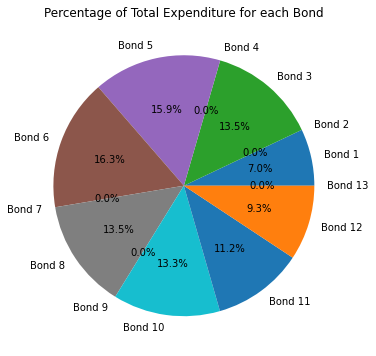

    Bond  Number of Bonds
0      1      6522.491727
1      2         0.000000
2      3     12848.616313
3      4         0.000000
4      5     15298.317884
5      6     15680.775832
6      7         0.000000
7      8     12308.006865
8      9         0.000000
9     10     12415.727483
10    11     10408.985681
11    12      9345.794393
12    13         0.000000

   Shadow Price   Lower Bound   Upper Bound  Liabities
0      0.971429  5.151384e+05           inf    1200000
1      0.923671  4.701682e+05  2.205234e+07    1800000
2      0.909876  4.319224e+05  3.106210e+07    2000000
3      0.834424  3.691993e+05  2.089037e+07    2000000
4      0.653628  2.584273e+05  1.075133e+07    1600000
5      0.617183  1.591014e+05  1.261887e+07    1500000
6      0.530350  6.542056e+04  1.197295e+07    1200000
7      0.522580 -1.164153e-10  1.582050e+07    1000000


In [18]:
#Let's bring the actual data and put them in our function. 
find_cf(df,df2,1, plot=True)

In [19]:
#After scraping the bonds information, read it as csv,
#Make the data cleaned deleting unnecessary column. 
#Show the data frame. 
wsj_data = pd.read_csv('Bonds_WSJ.csv')
wsj_data.drop('Unnamed: 0',axis=1,inplace=True)
wsj_data

,Bond,Price,Coupon,StartTime,Maturity
0,1,101.066,1.500,0,1
1,2,101.104,1.625,0,1
2,3,106.032,7.250,0,1
3,4,99.242,0.125,0,2
4,5,104.050,2.500,0,2
5,6,111.036,6.250,0,2
6,7,99.204,0.375,0,3
7,8,105.106,2.375,0,3
8,9,104.240,2.000,0,4
9,10,123.110,6.875,0,4


Optimal Value: 11700844.354872877


/var/folders/gp/5lrc5h3s21d02v2rsj713dxw0000gn/T/ipykernel_22784/1726699220.py:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  find_cf(df,wsj_data, plot=True)


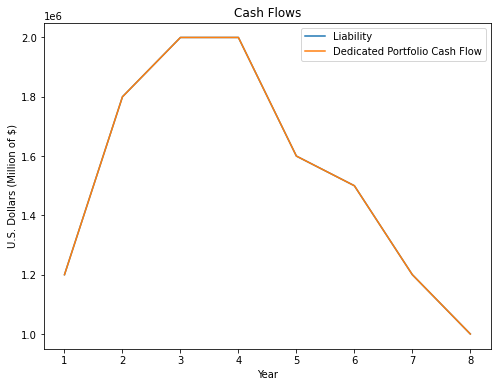

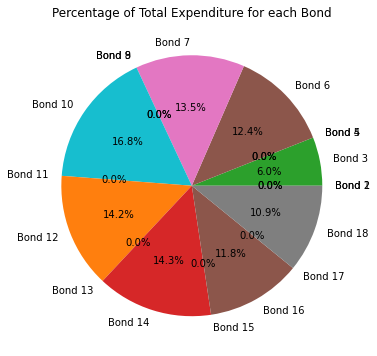

    Bond  Number of Bonds
0      1         0.000000
1      2         0.000000
2      3      6649.949565
3      4         0.000000
4      5         0.000000
5      6     13132.070909
6      7     15952.825341
7      8         0.000000
8      9         0.000000
9     10     16012.648436
10    11         0.000000
11    12     13113.518016
12    13         0.000000
13    14     12998.680482
14    15         0.000000
15    16     10827.346362
16    17         0.000000
17    18      9422.850412

   Shadow Price    Lower Bound   Upper Bound  Liabities
0      0.988345  486792.909121           inf    1200000
1      0.986568  404717.465941  1.392452e+07    1800000
2      0.978923  398735.156438  2.048331e+08    2000000
3      0.960864  288648.198443  1.382425e+07    2000000
4      0.942162  200131.951838  1.445613e+07    1600000
5      0.921622  117265.363768  1.598017e+07    1500000
6      0.902543   57714.958775  1.890694e+07    1200000
7      0.886490      -0.000000  1.787399e+07    1000000


In [20]:
#With the real data, find the objective value and the number of each bond which should be bought. 
find_cf(df,wsj_data, plot=True)